In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms import functional as F
from albumentations import Compose, Normalize, HorizontalFlip, RandomCrop
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# --- Параметры ---
IMAGE_DIR = "/kaggle/input/woodscape/woodscape/semantic_annotations/rgbImages"  # Путь к папке с изображениями
LABEL_DIR = "/kaggle/input/woodscape/woodscape/semantic_annotations/rgbLabels"  # Путь к папке с масками
BATCH_SIZE = 4
NUM_CLASSES = 2  # Два класса: разметка или нет разметки
NUM_EPOCHS = 25
ACCUMULATION_STEPS = 4  # Для градиентного накопления
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# --- Кастомный Dataset ---
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = self._match_label_files(self.image_files, label_dir)
        self.transform = transform

    def _match_label_files(self, image_files, label_dir):
        """
        Фильтрует файлы масок, оставляя только те, которые соответствуют изображениям.
        """
        valid_files = []
        for image_file in image_files:
            label_file = image_file.replace("_prev", "")
            label_path = os.path.join(label_dir, label_file)
            if os.path.exists(label_path):
                valid_files.append(label_file)
        return valid_files

    def __len__(self):
        return len(self.label_files)

    def __getitem__(self, idx):
        label_file = self.label_files[idx]
        image_file = label_file.replace(".png", "_prev.png")

        image_path = os.path.join(self.image_dir, image_file)
        label_path = os.path.join(self.label_dir, label_file)

        # Загрузка изображения и маски
        image = np.array(Image.open(image_path).convert("RGB"))
        label = np.array(Image.open(label_path))

        # Преобразование маски: выделение только класса (0, 0, 255)
        label = self._convert_to_binary_mask(label)

        # Применение трансформаций
        if self.transform:
            augmented = self.transform(image=image, mask=label)
            image = augmented["image"]
            label = augmented["mask"]

        return image, label.long()

    @staticmethod
    def _convert_to_binary_mask(label):
        """
        Преобразует маску в бинарный формат:
        - Все пиксели с цветом (0, 0, 255) становятся 1 (разметка).
        - Остальные пиксели становятся 0 (фон).
        """
        binary_mask = np.zeros(label.shape[:2], dtype=np.uint8)
        binary_mask[(label[:, :, 0] == 0) & (label[:, :, 1] == 0) & (label[:, :, 2] == 255)] = 1
        return binary_mask

In [4]:
# --- Аугментации ---
train_transform = Compose([
    HorizontalFlip(p=0.5),
    RandomCrop(512, 512),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = Compose([
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [5]:
# --- Датасеты и DataLoader ---
train_dataset = CustomDataset(IMAGE_DIR, LABEL_DIR, transform=train_transform)
val_dataset = CustomDataset(IMAGE_DIR, LABEL_DIR, transform=val_transform)

print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер валидационного датасета: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Размер тренировочного датасета: 8234
Размер валидационного датасета: 8234


In [6]:

# --- Модель ---
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(DEVICE)

# --- Оптимизатор и функция потерь ---
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 196MB/s]  


In [7]:

# --- Обучающий цикл ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    for images, masks in tqdm(loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)["out"]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            running_loss += loss.item()
    return running_loss / len(loader)


In [8]:
# --- Для смешанной точности ---
scaler = torch.amp.GradScaler("cuda")

# --- Основной цикл обучения ---
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
    torch.cuda.empty_cache()  # Освобождение памяти перед каждой эпохой
    model.train()
    
    # --- Обучение ---
    train_loss = 0.0
    optimizer.zero_grad()
    for i, (images, masks) in enumerate(tqdm(train_loader, desc="Training")):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # Смешанная точность
        with torch.amp.autocast("cuda"):
            outputs = model(images)
            loss = criterion(outputs["out"], masks)
            loss = loss / ACCUMULATION_STEPS  # Учет накопления

        # Обратное распространение
        scaler.scale(loss).backward()

        # Обновление градиентов каждые ACCUMULATION_STEPS шагов
        if (i + 1) % ACCUMULATION_STEPS == 0 or (i + 1) == len(train_loader):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * ACCUMULATION_STEPS

    train_loss /= len(train_loader)
    print(f"Train Loss: {train_loss:.4f}")

    # --- Валидация каждые 5 эпох ---
    if (epoch + 1) % 5 == 0:
        print("Starting validation on 100 images...")
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (images, masks) in enumerate(tqdm(val_loader, desc="Validation")):
                if i >= 100:  # Проверяем только на первых 100 батчах
                    break
                images, masks = images.to(DEVICE), masks.to(DEVICE)

                with torch.amp.autocast("cuda"):
                    outputs = model(images)
                    loss = criterion(outputs["out"], masks)

                val_loss += loss.item()

        val_loss /= min(len(val_loader), 100)
        print(f"Val Loss: {val_loss:.4f}")

    # --- Сохранение модели каждые 5 эпох ---
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"deeplabv3p_epoch{epoch + 1}.pth")

# --- Финальное сохранение модели ---
torch.save(model.state_dict(), "deeplabv3p_final.pth")


Epoch 1/25


Training: 100%|██████████| 2059/2059 [24:28<00:00,  1.40it/s]


Train Loss: 0.1139
Epoch 2/25


Training: 100%|██████████| 2059/2059 [19:30<00:00,  1.76it/s]


Train Loss: 0.0932
Epoch 3/25


Training: 100%|██████████| 2059/2059 [18:45<00:00,  1.83it/s]


Train Loss: 0.0870
Epoch 4/25


Training: 100%|██████████| 2059/2059 [18:28<00:00,  1.86it/s]


Train Loss: 0.0824
Epoch 5/25


Training: 100%|██████████| 2059/2059 [18:21<00:00,  1.87it/s]


Train Loss: 0.0823
Starting validation on 100 images...


Validation:   5%|▍         | 100/2059 [01:18<25:33,  1.28it/s]


Val Loss: 0.0629
Epoch 6/25


Training: 100%|██████████| 2059/2059 [18:18<00:00,  1.87it/s]


Train Loss: 0.0806
Epoch 7/25


Training: 100%|██████████| 2059/2059 [18:12<00:00,  1.89it/s]


Train Loss: 0.0775
Epoch 8/25


Training: 100%|██████████| 2059/2059 [18:08<00:00,  1.89it/s]


Train Loss: 0.0759
Epoch 9/25


Training: 100%|██████████| 2059/2059 [18:12<00:00,  1.89it/s]


Train Loss: 0.0744
Epoch 10/25


Training: 100%|██████████| 2059/2059 [18:09<00:00,  1.89it/s]


Train Loss: 0.0746
Starting validation on 100 images...


Validation:   5%|▍         | 100/2059 [01:16<25:07,  1.30it/s]


Val Loss: 0.0514
Epoch 11/25


Training: 100%|██████████| 2059/2059 [18:03<00:00,  1.90it/s]


Train Loss: 0.0720
Epoch 12/25


Training: 100%|██████████| 2059/2059 [18:03<00:00,  1.90it/s]


Train Loss: 0.0700
Epoch 13/25


Training: 100%|██████████| 2059/2059 [18:01<00:00,  1.90it/s]


Train Loss: 0.0708
Epoch 14/25


Training: 100%|██████████| 2059/2059 [18:02<00:00,  1.90it/s]


Train Loss: 0.0692
Epoch 15/25


Training: 100%|██████████| 2059/2059 [18:01<00:00,  1.90it/s]


Train Loss: 0.0678
Starting validation on 100 images...


Validation:   5%|▍         | 100/2059 [01:18<25:32,  1.28it/s]


Val Loss: 0.0504
Epoch 16/25


Training: 100%|██████████| 2059/2059 [18:02<00:00,  1.90it/s]


Train Loss: 0.0674
Epoch 17/25


Training: 100%|██████████| 2059/2059 [18:00<00:00,  1.91it/s]


Train Loss: 0.0670
Epoch 18/25


Training: 100%|██████████| 2059/2059 [18:00<00:00,  1.91it/s]


Train Loss: 0.0662
Epoch 19/25


Training: 100%|██████████| 2059/2059 [17:58<00:00,  1.91it/s]


Train Loss: 0.0671
Epoch 20/25


Training: 100%|██████████| 2059/2059 [17:59<00:00,  1.91it/s]


Train Loss: 0.0651
Starting validation on 100 images...


Validation:   5%|▍         | 100/2059 [01:17<25:18,  1.29it/s]


Val Loss: 0.0509
Epoch 21/25


Training: 100%|██████████| 2059/2059 [17:57<00:00,  1.91it/s]


Train Loss: 0.0655
Epoch 22/25


Training: 100%|██████████| 2059/2059 [18:01<00:00,  1.90it/s]


Train Loss: 0.0661
Epoch 23/25


Training: 100%|██████████| 2059/2059 [18:02<00:00,  1.90it/s]


Train Loss: 0.0654
Epoch 24/25


Training: 100%|██████████| 2059/2059 [17:57<00:00,  1.91it/s]


Train Loss: 0.0658
Epoch 25/25


Training: 100%|██████████| 2059/2059 [17:57<00:00,  1.91it/s]


Train Loss: 0.0644
Starting validation on 100 images...


Validation:   5%|▍         | 100/2059 [01:17<25:19,  1.29it/s]


Val Loss: 0.0505


In [13]:
from torchvision import transforms

# --- Настройки ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "/kaggle/working/deeplabv3p_epoch20.pth"
IMAGE_PATH = "/kaggle/input/woodscape/woodscape/semantic_annotations/rgbImages/08149_MVL_prev.png"

# --- Инициализация модели ---
from torchvision.models.segmentation import deeplabv3_resnet50

model = deeplabv3_resnet50(pretrained=False, num_classes=2)
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# --- Удаление несоответствующих ключей ---
filtered_state_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(filtered_state_dict, strict=False)

model.to(DEVICE)
model.eval()

# --- Преобразование тестового изображения ---
image = Image.open(IMAGE_PATH).convert("RGB")
original_size = image.size  # Сохраняем исходный размер

transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Приведение изображения к фиксированному размеру
    transforms.ToTensor(),  # Преобразование в тензор
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

input_tensor = transform(image).unsqueeze(0).to(DEVICE)

# --- Прогнозирование ---
with torch.no_grad():
    with torch.amp.autocast("cuda"):
        output = model(input_tensor)["out"]

/tmp/ipykernel_23/2171635634.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


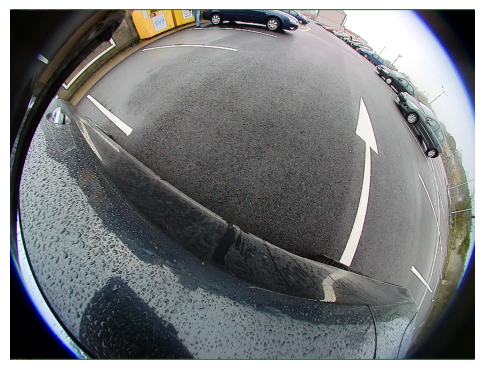

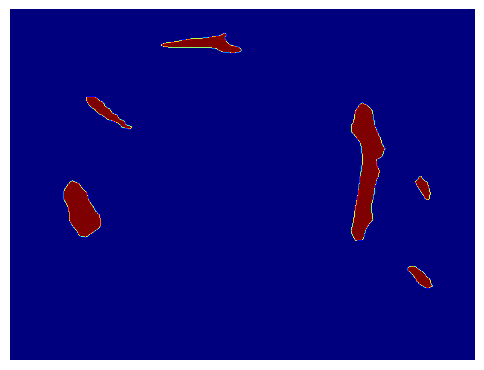

In [14]:
# Применяем сигмоиду, чтобы получить вероятности
probabilities = torch.sigmoid(output)

# Установите порог
threshold = 0.32
pred_mask = probabilities[0, 1, :, :].cpu().numpy() > threshold

# --- Масштабирование маски до исходного размера ---
pred_mask_resized = Image.fromarray(pred_mask.astype('uint8'))
pred_mask_resized = pred_mask_resized.resize(original_size, Image.NEAREST)
pred_mask_resized = np.array(pred_mask_resized)

# --- Отображение оригинала ---
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off')
plt.show()

# --- Отображение маски ---
plt.figure(figsize=(6, 6))
plt.imshow(pred_mask_resized, cmap="jet")
plt.axis('off')
plt.show()